In [1]:
## Rosa detection functions
import logging
import time
from cv2 import (
    findContours,
    contourArea,
    threshold,
    THRESH_BINARY,
    RETR_TREE,
    CHAIN_APPROX_SIMPLE,
    minEnclosingCircle, 
    minAreaRect,
    THRESH_TOZERO,
    circle,
    COLOR_BGR2GRAY,
    cvtColor,
    morphologyEx,
    MORPH_CLOSE
    )
import cv2
from fractions import Fraction
from decimal import Decimal
import numpy as np
from math import pi
from typing import TYPE_CHECKING

LOGGER = logging.getLogger(__name__)

ECCENTRICITY_CRITERIA = 0.7
IS_CONTOUR_EMPTY_CRITERIA = 0.4

R_25_um = 10/2048
R_75_um = 30/2048

R_TH_100um = 44/2048
R_TH_200um = 80/2048
R_300_um = 100/2048

R_TH = R_TH_200um
ALGO_TIMEOUT_IN_SECONDS = 0.5


def extract_gray_map_from_red_channel(image):
    b = image[:,:,0]
    r = image[:,:,2]
    red_channel = r >= b

    gray_level_img = cvtColor(image, COLOR_BGR2GRAY)

    out_img = red_channel*gray_level_img

    out_img = out_img.astype(np.uint8)
    return out_img

class ConnectedComponents:
    def __init__(self):
        self.area_list = []
        self.centroid_list = []
        self.minor_axis_list = []
        self.major_axis_list = []
        self.radius_list = []
        self.contour = []

    def get_properties_connected_component(self, binary_image):
        try:
            _, contours, _ = findContours(
                binary_image, RETR_TREE, CHAIN_APPROX_SIMPLE)
        except:
            contours, _ = findContours(
                binary_image, RETR_TREE, CHAIN_APPROX_SIMPLE)
        
        for cntr in contours:
            if len(cntr) > 4:
                area = contourArea(cntr)
                if int(area) > 15:
                    
                    center, radius = minEnclosingCircle(cntr)
                    
                    (_,_), (major_axis, minor_axis), _ = minAreaRect(cntr)

                    
                    self.centroid_list.append(center)
                    self.radius_list.append(radius)
                    area = pi * radius * radius
                    self.area_list.append(area)
                    self.major_axis_list.append(minor_axis / 2)
                    self.minor_axis_list.append(major_axis / 2)
                    self.contour.append(cntr)
    
def analyze_binary_image_for_rosa(binary_image):

    in_img_size = binary_image.shape

    cc = ConnectedComponents()
    cc.get_properties_connected_component(binary_image)
    if len(cc.area_list) >= 15:
        return False, 0, 0, 0

    t = time.time()
    list_idx = np.flip(np.argsort(cc.area_list), 0)

    if len(cc.area_list) > 0:
        area_number = len(cc.area_list)
        if area_number > 1:
            LOGGER.debug("Multiple areas:" + str(area_number))
        for idx in list_idx:
            circle_centroid = cc.centroid_list[idx]
            circle_radius = cc.radius_list[idx]
            if int(circle_radius) > int(R_75_um * in_img_size[0]) and int(circle_radius) <= int(R_300_um * in_img_size[0]):
                minor_axis = np.min([cc.minor_axis_list[idx], cc.major_axis_list[idx]])
                major_axis = np.max([cc.minor_axis_list[idx], cc.major_axis_list[idx]])
                is_a_circle = minor_axis/major_axis > ECCENTRICITY_CRITERIA
                if is_a_circle:
                    return True, float(circle_centroid[1]), float(circle_centroid[0]), float(circle_radius)
    return False, 0, 0, 0
    

def format_blob(in_image, laser_spot_parameter):
    captor_ratio = 1.18
    c_h, c_w, radius, found = laser_spot_parameter
    h, w = in_image.shape[0], in_image.shape[1]

    rectangle_height = min(h,w)
    rectangle_width = max(h,w)

    r, c = c_w, c_h

    radius = int(radius)
    blob = {
        'center': {
            "x": r / rectangle_width,
            "y": c / rectangle_height,
            "rx": r,
            "ry": c},
        'radius': float(
            Fraction(
                Fraction(
                    Decimal(radius)),
                h)),
        'rradius': radius,
        'found': found}
    return blob


def format_image(in_image: np.ndarray) -> np.ndarray:
    out_image = np.array(in_image, dtype=np.uint8)
    return out_image

def fine_tune_rosa_detection(red_channel, c_h, c_w, radius):
    h, w = np.shape(red_channel)
    c_h, c_w = int(c_h), int(c_w)

    c_h_orig, c_w_orig = int(c_h), int(c_w)
    original_radius = int(radius)

    h_crop = h/8
    w_crop = w/8
    h_min = np.amax([int(c_h-h_crop), 0])
    h_max = np.amin([int(c_h+h_crop), h])
    
    w_min = np.amax([int(c_w-w_crop), 0])
    w_max = np.amin([int(c_w+w_crop), h])

    crop_img = red_channel[h_min:h_max, w_min:w_max]

    new_img = np.zeros((h,w))
    new_img[h_min:h_max, w_min:w_max] = crop_img
    perc = int(np.max([np.percentile(crop_img, 95) - 1, 0]))

    in_img_size = red_channel.shape
    if int(perc) == 0:
        return c_h, c_w, original_radius
 
    else:
        _, binary_image = threshold(new_img, int(perc), 255, THRESH_BINARY)

        binary_image = binary_image.astype(np.uint8)
        found, c_h, c_w, radius = analyze_binary_image_for_rosa(binary_image)
        if found:
            return c_h, c_w, radius
        else:
            return c_h_orig, c_w_orig, original_radius
    return c_h_orig, c_w_orig, original_radius


def find_laser_spot_main_call(in_image: np.ndarray):
    formatted_image = format_image(in_image)

    time_start = time.time()
    red_channel = extract_gray_map_from_red_channel(formatted_image)
    max_value_red_channel = np.max(red_channel)
 
    found, rec_time, c_h, c_w, radius = find_laser_spot_recursive(
        red_channel, 0.95, max_value_red_channel, time_start, 0)

    if found:
        c_h, c_w, fine_tuned_radius = fine_tune_rosa_detection(red_channel, c_h, c_w, radius)
        radius = fine_tuned_radius

    blob = format_blob(in_image, [c_h, c_w, radius, found])
    time_elapsed = (time.time() - time_start)

    laser_found = "Laser found" if found else "Laser NOT found"

    LOGGER.warning(
        str.format(
            "{0}. Took {1}. Recursive count {2}",
            laser_found,
            str(time_elapsed),
            str(rec_time)))

    return blob, rec_time, found


def find_laser_spot_recursive(red_channel, thr, max_value, start_time, rec_time):
    rec_time = rec_time + 1

    binary_image = binarize_laser_image(red_channel, thr, max_value)

    current_time = time.time() - start_time
    if current_time > ALGO_TIMEOUT_IN_SECONDS:
        LOGGER.warning(
            str.format(
                "Laser spot not found - too long: Took {0} for {1} iteration.",
                str(current_time),
                rec_time))
        return False, rec_time, 0, 0, 0

    if thr < 0.4:
        LOGGER.debug(
            str.format(
                "Laser spot not found after {0} iteration in {1}",
                rec_time,
                str(current_time)))
        return False, rec_time, 0, 0, 0

    found, c_h, c_w, circle_radius = analyze_binary_image_for_rosa(binary_image)
    if found:
        return True, rec_time, c_h, c_w, circle_radius
    
    else:
        th = thr - 0.1
        return find_laser_spot_recursive(red_channel, th, max_value, start_time, rec_time)


def binarize_laser_image(input_image, thresh, max_value):
    gray_image = input_image
    max = max_value

    half_range = 3
    retval, binary_image = threshold(
        gray_image, int(max * thresh)-half_range, 255, THRESH_TOZERO)
    retval, binary_image = threshold(
        binary_image, int(max * thresh)+half_range, 255, THRESH_BINARY)
    

    return binary_image


# if __name__ == "__main__":
def mainRosa(image_path):
    import matplotlib.pyplot as plt
    import os
#     path = os.path.abspath(os.getcwd())
#     image_path = os.path.join(path, 'eye5-92-3097_laser.jpeg')
    # image_path = os.path.join(path, 'eye1-39-2521_laser.jpeg')
#     image_path='./2222/002.jpg'

    image = cv2.imread(image_path)
    image_size = image.shape

    blob, rec_time, found = find_laser_spot_main_call(image)
    
#     center = (int(blob['center']['x']*image_size[1]), int(blob['center']['y']*image_size[0]))
#     radius = int(blob['radius']*image_size[0])
#     cv2.circle(image, center, radius, (255,0,0), 2)

#     image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
#     plt.imshow(image_rgb)
#     plt.show()


    return blob

 

2
./zilia/singe26/oeilDroit_singe26/20200303_100701_psr/002.jpg


Laser found. Took 0.6386837959289551. Recursive count 3


2
4
./zilia/singe26/oeilDroit_singe26/20200303_100701_psr/004.jpg


Laser found. Took 0.08076095581054688. Recursive count 2


4
6
./zilia/singe26/oeilDroit_singe26/20200303_100701_psr/006.jpg


Laser found. Took 0.09765195846557617. Recursive count 2


6


Laser found. Took 0.09170031547546387. Recursive count 3


8
./zilia/singe26/oeilDroit_singe26/20200303_100701_psr/008.jpg
8


Laser found. Took 0.07005620002746582. Recursive count 3


10
./zilia/singe26/oeilDroit_singe26/20200303_100701_psr/010.jpg
10
12
./zilia/singe26/oeilDroit_singe26/20200303_100701_psr/012.jpg


Laser found. Took 0.07709693908691406. Recursive count 2


12
14
./zilia/singe26/oeilDroit_singe26/20200303_100701_psr/014.jpg


Laser found. Took 0.0755300521850586. Recursive count 2


14
16
./zilia/singe26/oeilDroit_singe26/20200303_100701_psr/016.jpg


Laser found. Took 0.08841800689697266. Recursive count 3


16
18
./zilia/singe26/oeilDroit_singe26/20200303_100701_psr/018.jpg


Laser found. Took 0.08851504325866699. Recursive count 2


18
20
./zilia/singe26/oeilDroit_singe26/20200303_100701_psr/020.jpg


Laser found. Took 0.11469531059265137. Recursive count 2


20
22
./zilia/singe26/oeilDroit_singe26/20200303_100701_psr/022.jpg


Laser found. Took 0.13602519035339355. Recursive count 2


22
24
./zilia/singe26/oeilDroit_singe26/20200303_100701_psr/024.jpg


Laser found. Took 0.08217597007751465. Recursive count 3


24
26
./zilia/singe26/oeilDroit_singe26/20200303_100701_psr/026.jpg


Laser found. Took 0.0823369026184082. Recursive count 2


26
28
./zilia/singe26/oeilDroit_singe26/20200303_100701_psr/028.jpg


Laser found. Took 0.06946587562561035. Recursive count 2


28
30
./zilia/singe26/oeilDroit_singe26/20200303_100701_psr/030.jpg


Laser found. Took 0.07722687721252441. Recursive count 2


30


Laser found. Took 0.06786894798278809. Recursive count 2


32
./zilia/singe26/oeilDroit_singe26/20200303_100701_psr/032.jpg
32
34
./zilia/singe26/oeilDroit_singe26/20200303_100701_psr/034.jpg


Laser found. Took 0.08737993240356445. Recursive count 3


34
36
./zilia/singe26/oeilDroit_singe26/20200303_100701_psr/036.jpg


Laser found. Took 0.1001589298248291. Recursive count 2


36
38
./zilia/singe26/oeilDroit_singe26/20200303_100701_psr/038.jpg


Laser found. Took 0.09557080268859863. Recursive count 2


38
40
./zilia/singe26/oeilDroit_singe26/20200303_100701_psr/040.jpg


Laser found. Took 0.11342310905456543. Recursive count 3


40
42
./zilia/singe26/oeilDroit_singe26/20200303_100701_psr/042.jpg


Laser found. Took 0.11580801010131836. Recursive count 2


42
44
./zilia/singe26/oeilDroit_singe26/20200303_100701_psr/044.jpg


Laser found. Took 0.11550283432006836. Recursive count 2


44
46
./zilia/singe26/oeilDroit_singe26/20200303_100701_psr/046.jpg


Laser found. Took 0.10223937034606934. Recursive count 2


46


Laser found. Took 0.08331489562988281. Recursive count 2


48
./zilia/singe26/oeilDroit_singe26/20200303_100701_psr/048.jpg
48
50
./zilia/singe26/oeilDroit_singe26/20200303_100701_psr/050.jpg


Laser found. Took 0.09451007843017578. Recursive count 3


50
52
./zilia/singe26/oeilDroit_singe26/20200303_100701_psr/052.jpg


Laser found. Took 0.1350409984588623. Recursive count 2


52
54
./zilia/singe26/oeilDroit_singe26/20200303_100701_psr/054.jpg


Laser found. Took 0.10117721557617188. Recursive count 3


54
56
./zilia/singe26/oeilDroit_singe26/20200303_100701_psr/056.jpg


Laser found. Took 0.1294701099395752. Recursive count 3


56
58
./zilia/singe26/oeilDroit_singe26/20200303_100701_psr/058.jpg


Laser found. Took 0.08472394943237305. Recursive count 4


58
60
./zilia/singe26/oeilDroit_singe26/20200303_100701_psr/060.jpg


Laser found. Took 0.120697021484375. Recursive count 3


60
62
./zilia/singe26/oeilDroit_singe26/20200303_100701_psr/062.jpg


Laser found. Took 0.12401986122131348. Recursive count 3


62
64
./zilia/singe26/oeilDroit_singe26/20200303_100701_psr/064.jpg


Laser found. Took 0.08548307418823242. Recursive count 2


64
66
./zilia/singe26/oeilDroit_singe26/20200303_100701_psr/066.jpg


Laser found. Took 0.2547900676727295. Recursive count 2


66
68
./zilia/singe26/oeilDroit_singe26/20200303_100701_psr/068.jpg


Laser found. Took 0.10279393196105957. Recursive count 2


68


Laser found. Took 0.0694739818572998. Recursive count 2


70
./zilia/singe26/oeilDroit_singe26/20200303_100701_psr/070.jpg
70
72
./zilia/singe26/oeilDroit_singe26/20200303_100701_psr/072.jpg


Laser found. Took 0.09066390991210938. Recursive count 3


72
74
./zilia/singe26/oeilDroit_singe26/20200303_100701_psr/074.jpg


Laser found. Took 0.09915804862976074. Recursive count 2


74
76
./zilia/singe26/oeilDroit_singe26/20200303_100701_psr/076.jpg


Laser found. Took 0.07814812660217285. Recursive count 2


76


Laser found. Took 0.05408000946044922. Recursive count 2


78
./zilia/singe26/oeilDroit_singe26/20200303_100701_psr/078.jpg
78


Laser found. Took 0.05661201477050781. Recursive count 2


80
./zilia/singe26/oeilDroit_singe26/20200303_100701_psr/080.jpg
80


Laser found. Took 0.05350184440612793. Recursive count 2


82
./zilia/singe26/oeilDroit_singe26/20200303_100701_psr/082.jpg
82


Laser found. Took 0.05443000793457031. Recursive count 2


84
./zilia/singe26/oeilDroit_singe26/20200303_100701_psr/084.jpg
84


Laser found. Took 0.0909719467163086. Recursive count 2


86
./zilia/singe26/oeilDroit_singe26/20200303_100701_psr/086.jpg
86


Laser found. Took 0.060569047927856445. Recursive count 3


88
./zilia/singe26/oeilDroit_singe26/20200303_100701_psr/088.jpg
88


Laser found. Took 0.06059002876281738. Recursive count 3


90
./zilia/singe26/oeilDroit_singe26/20200303_100701_psr/090.jpg
90


Laser found. Took 0.0566411018371582. Recursive count 2


92
./zilia/singe26/oeilDroit_singe26/20200303_100701_psr/092.jpg
92


Laser found. Took 0.0627601146697998. Recursive count 3


94
./zilia/singe26/oeilDroit_singe26/20200303_100701_psr/094.jpg
94


Laser found. Took 0.05871415138244629. Recursive count 2


96
./zilia/singe26/oeilDroit_singe26/20200303_100701_psr/096.jpg
96


Laser found. Took 0.0864567756652832. Recursive count 2


98
./zilia/singe26/oeilDroit_singe26/20200303_100701_psr/098.jpg
98


Laser found. Took 0.058924198150634766. Recursive count 2


100
./zilia/singe26/oeilDroit_singe26/20200303_100701_psr/100.jpg
100


Laser found. Took 0.09360527992248535. Recursive count 2


102
./zilia/singe26/oeilDroit_singe26/20200303_100701_psr/102.jpg
102


Laser found. Took 0.08490705490112305. Recursive count 2


104
./zilia/singe26/oeilDroit_singe26/20200303_100701_psr/104.jpg
104


Laser found. Took 0.10712695121765137. Recursive count 2


106
./zilia/singe26/oeilDroit_singe26/20200303_100701_psr/106.jpg
106


Laser found. Took 0.06459903717041016. Recursive count 2


108
./zilia/singe26/oeilDroit_singe26/20200303_100701_psr/108.jpg
108


Laser found. Took 0.058528900146484375. Recursive count 2


110
./zilia/singe26/oeilDroit_singe26/20200303_100701_psr/110.jpg
110


Laser found. Took 0.0814049243927002. Recursive count 4


112
./zilia/singe26/oeilDroit_singe26/20200303_100701_psr/112.jpg
112


Laser found. Took 0.10732078552246094. Recursive count 4


114
./zilia/singe26/oeilDroit_singe26/20200303_100701_psr/114.jpg
114


Laser NOT found. Took 0.08521699905395508. Recursive count 7


116
./zilia/singe26/oeilDroit_singe26/20200303_100701_psr/116.jpg


Laser NOT found. Took 0.0733330249786377. Recursive count 7


118
./zilia/singe26/oeilDroit_singe26/20200303_100701_psr/118.jpg


Laser NOT found. Took 0.07832813262939453. Recursive count 7


120
./zilia/singe26/oeilDroit_singe26/20200303_100701_psr/120.jpg


Laser NOT found. Took 0.07812714576721191. Recursive count 7


122
./zilia/singe26/oeilDroit_singe26/20200303_100701_psr/122.jpg


Laser NOT found. Took 0.10739827156066895. Recursive count 7


124
./zilia/singe26/oeilDroit_singe26/20200303_100701_psr/124.jpg


Laser NOT found. Took 0.06169891357421875. Recursive count 7


126
./zilia/singe26/oeilDroit_singe26/20200303_100701_psr/126.jpg
128
./zilia/singe26/oeilDroit_singe26/20200303_100701_psr/128.jpg


Laser found. Took 0.12094783782958984. Recursive count 4


128


Laser found. Took 0.07754015922546387. Recursive count 4


130
./zilia/singe26/oeilDroit_singe26/20200303_100701_psr/130.jpg
130
132
./zilia/singe26/oeilDroit_singe26/20200303_100701_psr/132.jpg


Laser NOT found. Took 0.18250298500061035. Recursive count 7
Laser NOT found. Took 0.09621882438659668. Recursive count 7


134
./zilia/singe26/oeilDroit_singe26/20200303_100701_psr/134.jpg
136
./zilia/singe26/oeilDroit_singe26/20200303_100701_psr/136.jpg


Laser NOT found. Took 0.1791071891784668. Recursive count 7
Laser found. Took 0.09079194068908691. Recursive count 4


138
./zilia/singe26/oeilDroit_singe26/20200303_100701_psr/138.jpg
138
140
./zilia/singe26/oeilDroit_singe26/20200303_100701_psr/140.jpg


Laser NOT found. Took 0.1682140827178955. Recursive count 7


142
./zilia/singe26/oeilDroit_singe26/20200303_100701_psr/142.jpg


Laser NOT found. Took 0.1690208911895752. Recursive count 7


144
./zilia/singe26/oeilDroit_singe26/20200303_100701_psr/144.jpg


Laser NOT found. Took 0.22010016441345215. Recursive count 7


146
./zilia/singe26/oeilDroit_singe26/20200303_100701_psr/146.jpg


Laser NOT found. Took 0.1751699447631836. Recursive count 7


148
./zilia/singe26/oeilDroit_singe26/20200303_100701_psr/148.jpg


Laser NOT found. Took 0.2083601951599121. Recursive count 7
Laser NOT found. Took 0.057604074478149414. Recursive count 7


150
./zilia/singe26/oeilDroit_singe26/20200303_100701_psr/150.jpg


Laser found. Took 0.10374331474304199. Recursive count 5


152
./zilia/singe26/oeilDroit_singe26/20200303_100701_psr/152.jpg
152
154
./zilia/singe26/oeilDroit_singe26/20200303_100701_psr/154.jpg


Laser found. Took 0.23565196990966797. Recursive count 5


154
156
./zilia/singe26/oeilDroit_singe26/20200303_100701_psr/156.jpg


Laser NOT found. Took 0.43569517135620117. Recursive count 7
Laser NOT found. Took 0.07500910758972168. Recursive count 7


158
./zilia/singe26/oeilDroit_singe26/20200303_100701_psr/158.jpg


Laser NOT found. Took 0.12500524520874023. Recursive count 7


160
./zilia/singe26/oeilDroit_singe26/20200303_100701_psr/160.jpg


Laser found. Took 0.09346795082092285. Recursive count 4


162
./zilia/singe26/oeilDroit_singe26/20200303_100701_psr/162.jpg
162


Laser NOT found. Took 0.05716419219970703. Recursive count 7


164
./zilia/singe26/oeilDroit_singe26/20200303_100701_psr/164.jpg


Laser NOT found. Took 0.05107712745666504. Recursive count 7


166
./zilia/singe26/oeilDroit_singe26/20200303_100701_psr/166.jpg


Laser NOT found. Took 0.05571794509887695. Recursive count 7


168
./zilia/singe26/oeilDroit_singe26/20200303_100701_psr/168.jpg


Laser NOT found. Took 0.052340030670166016. Recursive count 7


170
./zilia/singe26/oeilDroit_singe26/20200303_100701_psr/170.jpg


Laser NOT found. Took 0.05337405204772949. Recursive count 7


172
./zilia/singe26/oeilDroit_singe26/20200303_100701_psr/172.jpg


Laser NOT found. Took 0.0510098934173584. Recursive count 7


174
./zilia/singe26/oeilDroit_singe26/20200303_100701_psr/174.jpg


Laser NOT found. Took 0.05414390563964844. Recursive count 7


176
./zilia/singe26/oeilDroit_singe26/20200303_100701_psr/176.jpg


Laser NOT found. Took 0.051418304443359375. Recursive count 7


178
./zilia/singe26/oeilDroit_singe26/20200303_100701_psr/178.jpg


Laser NOT found. Took 0.05151200294494629. Recursive count 7


180
./zilia/singe26/oeilDroit_singe26/20200303_100701_psr/180.jpg


Laser NOT found. Took 0.05110001564025879. Recursive count 7


182
./zilia/singe26/oeilDroit_singe26/20200303_100701_psr/182.jpg


Laser NOT found. Took 0.050560951232910156. Recursive count 7


184
./zilia/singe26/oeilDroit_singe26/20200303_100701_psr/184.jpg


Laser NOT found. Took 0.050479888916015625. Recursive count 7


186
./zilia/singe26/oeilDroit_singe26/20200303_100701_psr/186.jpg


Laser NOT found. Took 0.05041694641113281. Recursive count 7


188
./zilia/singe26/oeilDroit_singe26/20200303_100701_psr/188.jpg


Laser NOT found. Took 0.050765037536621094. Recursive count 7


190
./zilia/singe26/oeilDroit_singe26/20200303_100701_psr/190.jpg


Laser NOT found. Took 0.050394296646118164. Recursive count 7


192
./zilia/singe26/oeilDroit_singe26/20200303_100701_psr/192.jpg


Laser found. Took 0.0825049877166748. Recursive count 5


194
./zilia/singe26/oeilDroit_singe26/20200303_100701_psr/194.jpg
194
196
./zilia/singe26/oeilDroit_singe26/20200303_100701_psr/196.jpg


Laser found. Took 0.25475502014160156. Recursive count 3


196
198
./zilia/singe26/oeilDroit_singe26/20200303_100701_psr/198.jpg


Laser found. Took 0.15170812606811523. Recursive count 4


198


Laser found. Took 0.1173408031463623. Recursive count 5


200
./zilia/singe26/oeilDroit_singe26/20200303_100701_psr/200.jpg
200


Laser found. Took 0.0814359188079834. Recursive count 5


202
./zilia/singe26/oeilDroit_singe26/20200303_100701_psr/202.jpg
202
204
./zilia/singe26/oeilDroit_singe26/20200303_100701_psr/204.jpg


Laser NOT found. Took 0.16170287132263184. Recursive count 7
Laser found. Took 0.07848811149597168. Recursive count 3


206
./zilia/singe26/oeilDroit_singe26/20200303_100701_psr/206.jpg
206


Laser found. Took 0.07195901870727539. Recursive count 4


208
./zilia/singe26/oeilDroit_singe26/20200303_100701_psr/208.jpg
208
210
./zilia/singe26/oeilDroit_singe26/20200303_100701_psr/210.jpg


Laser found. Took 0.17754697799682617. Recursive count 3


210
212
./zilia/singe26/oeilDroit_singe26/20200303_100701_psr/212.jpg


Laser found. Took 0.15856385231018066. Recursive count 2


212


Laser found. Took 0.06626272201538086. Recursive count 2


214
./zilia/singe26/oeilDroit_singe26/20200303_100701_psr/214.jpg
214
216
./zilia/singe26/oeilDroit_singe26/20200303_100701_psr/216.jpg


Laser found. Took 0.10665106773376465. Recursive count 2


216
218
./zilia/singe26/oeilDroit_singe26/20200303_100701_psr/218.jpg


Laser found. Took 0.40331172943115234. Recursive count 2


218


Laser found. Took 0.0987100601196289. Recursive count 2


220
./zilia/singe26/oeilDroit_singe26/20200303_100701_psr/220.jpg
220
222
./zilia/singe26/oeilDroit_singe26/20200303_100701_psr/222.jpg


Laser found. Took 0.4008328914642334. Recursive count 3


222


Laser found. Took 0.09222412109375. Recursive count 3


224
./zilia/singe26/oeilDroit_singe26/20200303_100701_psr/224.jpg
224
226
./zilia/singe26/oeilDroit_singe26/20200303_100701_psr/226.jpg


Laser found. Took 0.13413023948669434. Recursive count 2


226
228
./zilia/singe26/oeilDroit_singe26/20200303_100701_psr/228.jpg


Laser found. Took 0.10800004005432129. Recursive count 2


228
(81, 2048, 2448)
(81, 2048, 2448)
(80,)
(80,)
(80,)


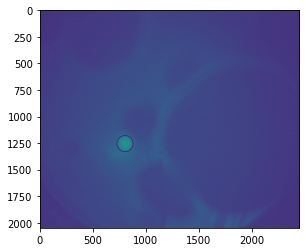

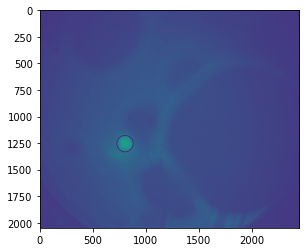

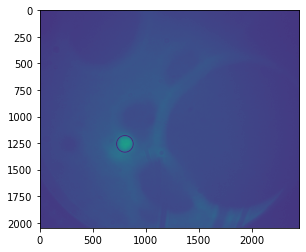

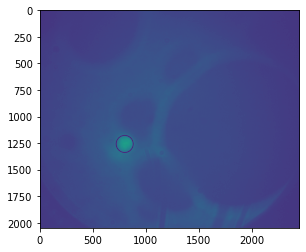

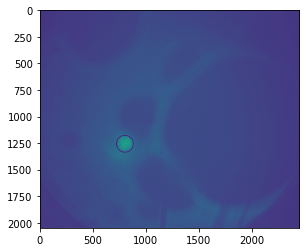

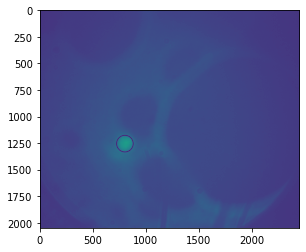

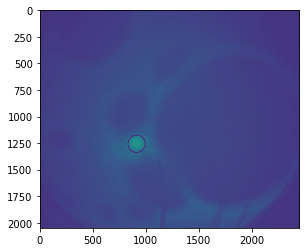

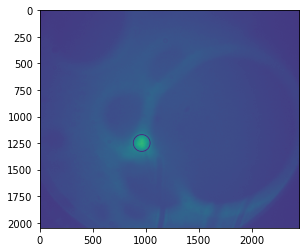

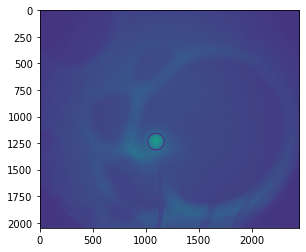

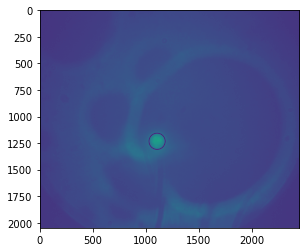

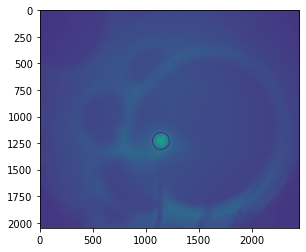

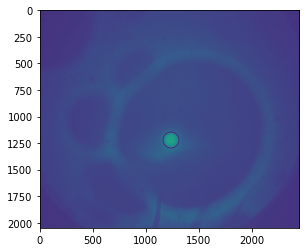

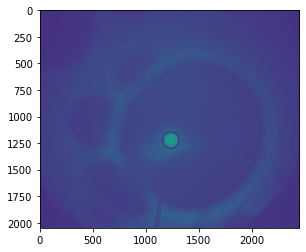

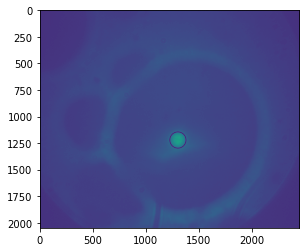

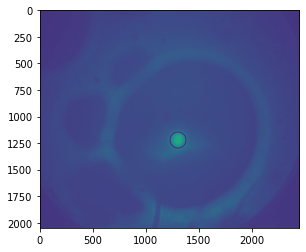

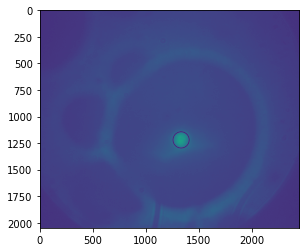

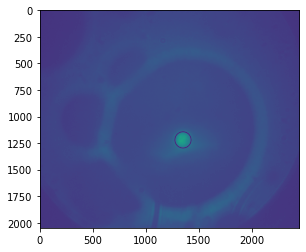

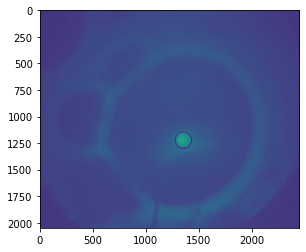

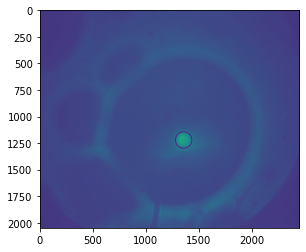

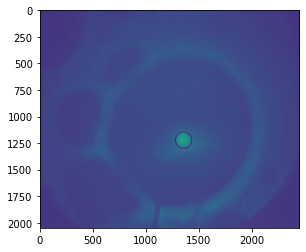

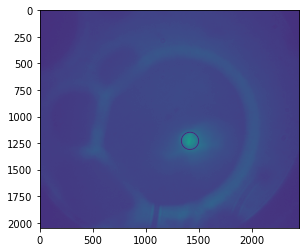

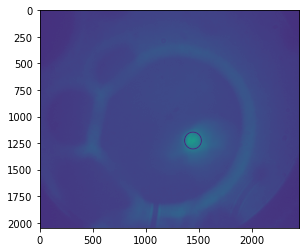

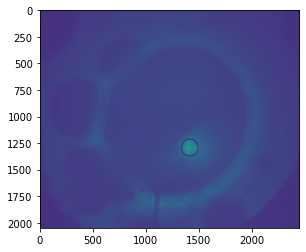

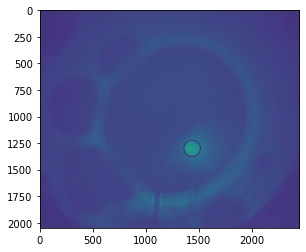

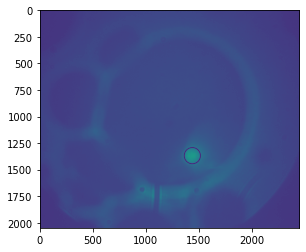

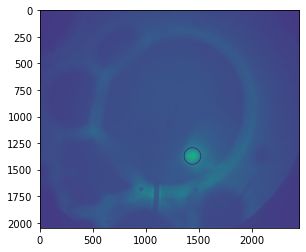

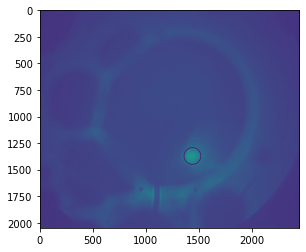

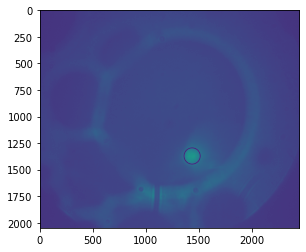

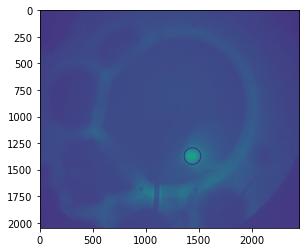

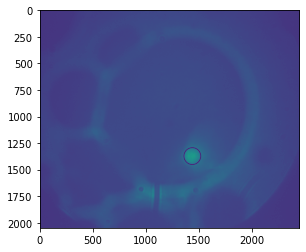

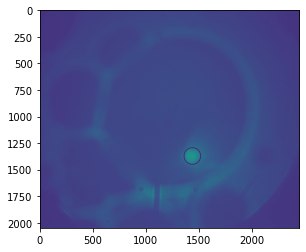

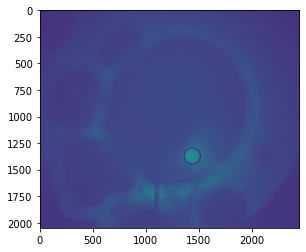

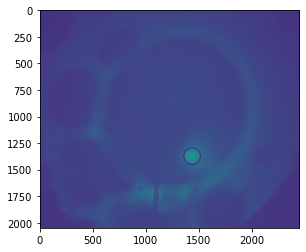

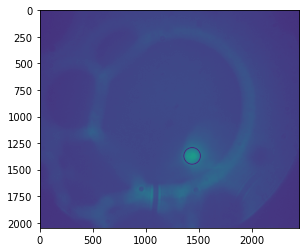

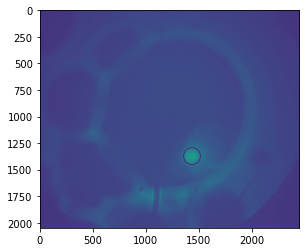

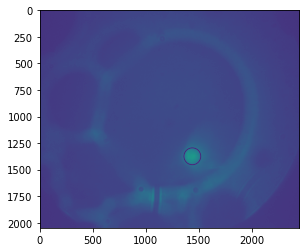

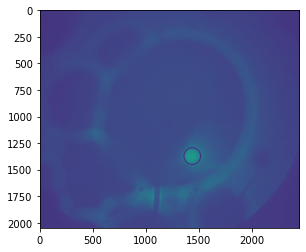

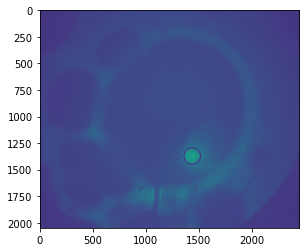

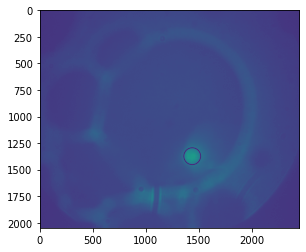

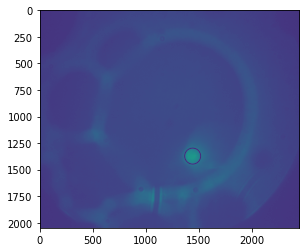

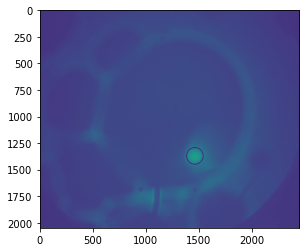

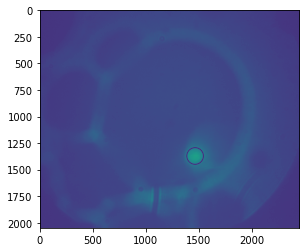

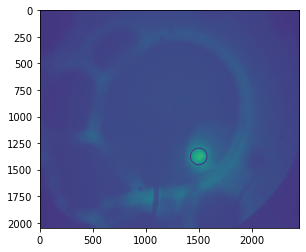

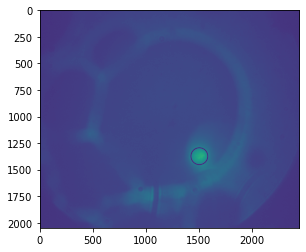

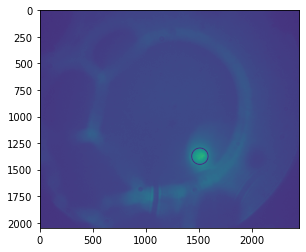

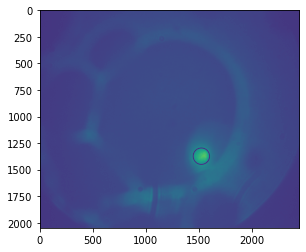

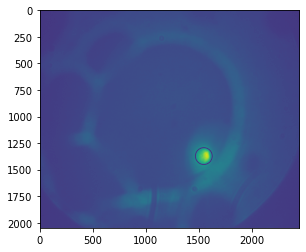

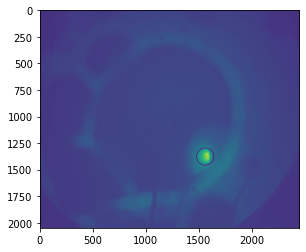

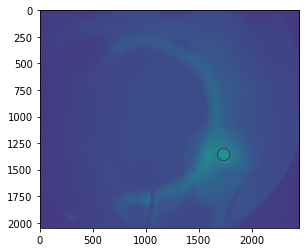

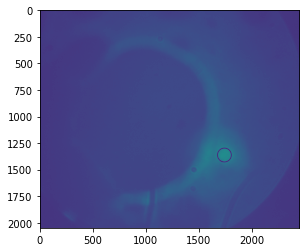

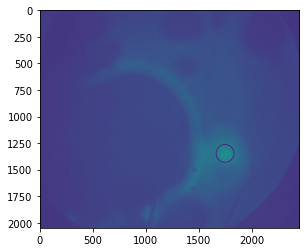

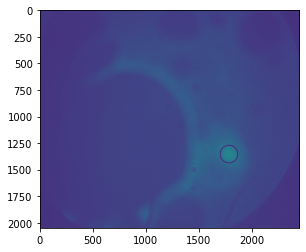

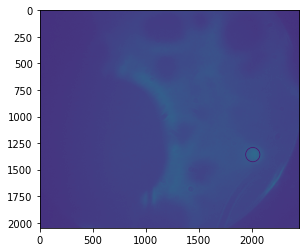

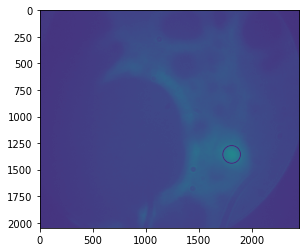

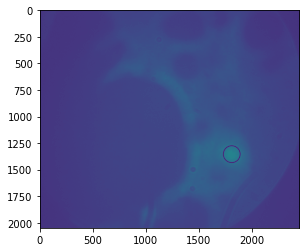

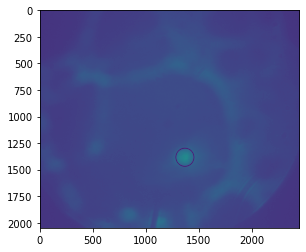

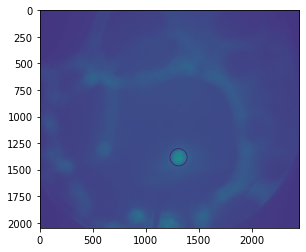

In [2]:
from skimage.io import imread_collection
from skimage.color import rgb2gray
import numpy as np
import cv2
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
import scipy.fftpack as fp
from matplotlib import pyplot
from scipy.signal import find_peaks
from scipy import ndimage
import scipy.signal


def loadImages(collectionDir):
    
    # this function get the directory of a series of images
    # blue channel of the image = 0
    # output is a series of grayscale images
    
    collectionDir=collectionDir+'*.jpg'
    imageCollection = imread_collection(collectionDir)
    grayImage=np.zeros((len(imageCollection),imageCollection[0].shape[0],imageCollection[0].shape[1]))
    for i in range(len(imageCollection)):
        imageCollection[i][:,:,2]=0
        grayImage[i,:,:]=rgb2gray(imageCollection[i])
    return grayImage
        


def intensityCheck(Image,laser,xLaser,yLaser,rLaser,imageNumber):
    
    # Purpose: remove images with low contrast or blury
    # 1- use laplacian filter to remove blury images
    # 2- use average intensity in retinal images for thresholding
    # input: series of retina images, series of rosa images, x,y, and radius of the rosa center
    #        , image number in the original folder
    # output: reduced data
    
    index=np.array([])
    ii=np.array([])
    for kk in range(Image.shape[0]):
        d1=Image[kk,:,:]
        d1=256*((d1-np.min(d1))/(np.max(d1)-np.min(d1)))
        resLap = cv2.Laplacian(d1, cv2.CV_64F)
        score = resLap.var()
        ii=np.hstack((ii,score))
    T=np.mean(ii)
    index=np.where(ii>T)
    Image=np.delete(Image,index,axis=0)
    laser=np.delete(laser,index,axis=0)
    xLaser=np.delete(xLaser,index,axis=0)
    yLaser=np.delete(yLaser,index,axis=0)
    rLaser=np.delete(rLaser,index,axis=0)
    imageNumber=np.delete(imageNumber,index,axis=0)
    return Image,laser,xLaser,yLaser,rLaser,imageNumber



def seperateImages(grayImageCollection,collectionDir):
    
    # Purpose: seperate retina images from rosa images
    # load retina image - then load the corresponding rosa image 
    # check to find the rosa, if found, append the image and other info a the numpy array
    # input: grayscale images (output of loadImages function), directory for the images folder
    # output: numpy arrays including: retina images ,rosa images, 
    #         x,y, and radius of rosa center, number of the images in the directoru

    Thresh=np.mean(grayImageCollection)
    counter=0
    Image=np.empty((1,grayImageCollection.shape[1], grayImageCollection.shape[2]), float)
    laserImage=np.empty((1,grayImageCollection.shape[1], grayImageCollection.shape[2]), float)
    temp=np.empty((1,grayImage.shape[1], grayImageCollection.shape[2]), float)
    xCenter=np.array([])
    yCenter=np.array([])
    radius=np.array([])
    imageNumber=np.array([])
    
    for i in range(1,grayImageCollection.shape[0]):
        if (np.mean(grayImageCollection[i-1,:,:])>Thresh and np.mean(grayImageCollection[i,:,:])<Thresh):
            print(i)
            if (i<10):
                loadLaserImage=collectionDir+'00'+str(i)+'.jpg'
            if (i>=9 and i<100):
                loadLaserImage=collectionDir+'0'+str(i)+'.jpg'
            if (i>=100):
                loadLaserImage=collectionDir+str(i)+'.jpg'
            print(loadLaserImage)
            blob=mainRosa(loadLaserImage)
            if (blob['found'] == True):
                temp[0,:,:]=grayImageCollection[i-1,:,:]
                Image=np.vstack((Image,temp))
                temp[0,:,:]=grayImageCollection[i,:,:]
                laserImage=np.vstack((laserImage,temp))

                xCenter=np.hstack((xCenter,int(blob['center']['x']*Image.shape[2])))
                yCenter=np.hstack((yCenter,int(blob['center']['y']*Image.shape[1])))
                radius=np.hstack((radius,int(blob['radius']*Image.shape[1])))
                imageNumber=np.hstack((imageNumber,int(i-1)))

    Image=np.delete(Image,0,axis=0)
    laserImage=np.delete(laserImage,0,axis=0)
    return Image,laserImage,xCenter,yCenter,radius,imageNumber



def cross_image(im1, im2):
    # calculate the cross correlation between two images
    # get rid of the averages, otherwise the results are not good
    # input: two 2D numpy arrays
    # output: cross correlation
    im1 -= np.mean(im1)
    im2 -= np.mean(im2)
    return scipy.signal.fftconvolve(im1, im2[::-1,::-1], mode='same')

def ImageShift(Image):
    
    # calculated the shift in x and y direction in two consecutive images
    # input: 3D numpy array (series of retina images)
    # the shift in the first image is considered to be zero
    # output: 2D numpy array with the shifts in each image regarding the first image
    
    Margin=250
    N=100
    temp=Image[:,Margin:Image.shape[1]-Margin,Margin:Image.shape[2]-Margin]
    skeletonImage=np.zeros(Image.shape)
    a=np.zeros(Image.shape)
    indexShift=np.array([0,0])
    totalShift=np.array([0,0])
    for j in range(temp.shape[0]):
        for i in range(temp.shape[1]):
            y=np.convolve(temp[j,i,:], np.ones(N)/N, mode='valid')
            peaks, properties = find_peaks(-y,prominence=0.001,distance=250)
            skeletonImage[j,i+Margin,peaks+Margin]=1
        for i in range(temp.shape[2]):
            y=np.convolve(temp[j,:,i], np.ones(N)/N, mode='valid')
            peaks, properties = find_peaks(-y,prominence=0.001,distance=250)
            skeletonImage[j,peaks+Margin,i+Margin]=1

        a[j,:,:]=ndimage.binary_closing(skeletonImage[j,:,:], structure=np.ones((20,20))).astype(np.int)
        
        if (j>0):
            out1=cross_image(a[j-1,:,:],a[j,:,:])
            ind= np.unravel_index(np.argmax(out1, axis=None), out1.shape)
            indexShift=np.vstack((indexShift,np.array(ind)-np.array([a.shape[1]/2,a.shape[2]/2])))
            totalShift=np.vstack((totalShift,np.sum(indexShift,axis=0)))
    return totalShift

def applyShift(xLaser,yLaser,shift):
    
    # apply the shift value on the x and y of the rosa
    
    return (xLaser-shift[:,1]),(yLaser-shift[:,0])

def defineGrid(Image):
    temp=np.zeros(Image.shape)
    temp[np.where(Image>=np.mean(Image)*1.9)]=1
    kernel = np.ones((5,5),np.uint8)
    openingTemp = cv2.morphologyEx(temp[0,:,:], cv2.MORPH_OPEN, kernel)
    nonZero=np.nonzero(openingTemp)
    upToDown=np.max(nonZero[0])-np.min(nonZero[0])
    rightToLeft=np.max(nonZero[1])-np.min(nonZero[1])
    upToDownCenter=int(((np.max(nonZero[0])+np.min(nonZero[0]))/2)-(upToDown-rightToLeft))
    rightToLeftCenter=int((np.max(nonZero[1])+np.min(nonZero[1]))/2)
    length=int((np.min([upToDown,rightToLeft]))/2)
    return rightToLeftCenter,upToDownCenter,length

def placeRosa(xCenterGrid,yCenterGrid,length,xRosa,yRosa):
    xLabel=np.array(['1','2','3','4','5','6','7','8','9','10'])
    yLabel=np.array(['A','B','C','D','E','F','J','K','L','M'])

    xGrid=np.array(range(-5*length,5*length))
    xlabel = np.array( ["" for x in range(xGrid.shape[0])])
    for x in range(xLabel.shape[0]):
        xlabel[x*length:(x+1)*length]=xLabel[x]
    yGrid=np.array(range(-5*length,5*length))
    ylabel = np.array( ["" for x in range(yGrid.shape[0])])
    for y in range(yLabel.shape[0]):
        ylabel[y*length:(y+1)*length]=yLabel[y]
    outputLabel=[]
    for j in range(xRosa.shape[0]):
        L=str(str(xlabel[(np.where(xGrid == xRosa[j]-xCenterGrid))[0]][0])+
                       str(ylabel[(np.where(yGrid == yRosa[j]-yCenterGrid))[0]][0]))
        outputLabel.append(L)
    return outputLabel


def plotResult (Image,length,xCenterGrid,yCenterGrid,xRosa,yRosa):
    for j in range(Image.shape[0]):
        window_name = 'Image'  
        center_coordinates = (int(xRosa[j]),int(yRosa[j]))
        radius = 30
        color = (0, 255, 0)
        thickness = 5
        image = cv2.circle(Image[0,:,:], center_coordinates, radius, color, thickness)
        left=np.max([xCenterGrid-(length*5),0])
        
    up=np.max([yCenterGrid-(length*5),0])
    right=np.min([(5*length),(Image.shape[1]-xCenterGrid)])+xCenterGrid
    down=right=np.min([(5*length),(Image.shape[2]-yCenterGrid)])+yCenterGrid
    temp=Image[0,up:down,left:right]
    xNewCenter=xCenterGrid-left
    yNewCenter=yCenterGrid-up
    gridImage=np.zeros([length*10,length*10])
    gridImage[((5*length)-yNewCenter):((5*length)+(temp.shape[0]-yNewCenter)),((5*length)-xNewCenter):((5*length)+(temp.shape[1]-xNewCenter))]=temp
    
    plt.figure()
    img=gridImage.copy()
    dx, dy = length,length

    # Custom (rgb) grid color
    grid_color = 0

    # Modify the image to include the grid
    img[:,::dy] = grid_color
    img[::dx,:] = grid_color

    plt.imshow(img)
    pyplot.imsave('Result.jpg',img)

    
    


            

# collectionDir = './zilia/20200228_140744_singe2/*.jpg'
# collectionDir = './1111/*.jpg'
# collectionDir = './2222/*.jpg'
# collectionDir='./2222/'
# collectionDir = './zilia/singe2/20200229_084156_singe2_scanRetine_day2/*.jpg'
# collectionDir = './zilia/Singe3/oeilDroit_singe3/20200229_090916_spectro180_RLP20/*.jpg'
# collectionDir = './zilia/Singe1/20200228_134918_/*.jpg'
# collectionDir = './zilia/Singe1/20200229_081046_Scan_singe1_day2/*.jpg'
# collectionDir = './zilia/Singe2/20200229_084156_singe2_scanRetine_day2/*.jpg'
# collectionDir = './zilia/singe26/oeilDroit_singe26/20200303_100701_psr/*.jpg'
collectionDir = './zilia/singe26/oeilDroit_singe26/20200303_100701_psr/'
# collectionDir = './zilia/singe27/oeilDroit_singe27/20200303_103016_psr/'
# collectionDir = './2222/'

grayImage=np.array([])
Image=np.array([])
laser=np.array([])
xLaser=np.array([])
yLaser=np.array([])
rLaser=np.array([])

grayImage=loadImages(collectionDir)
Image,laser,xLaser,yLaser,rLaser,imageNumber=seperateImages(grayImage,collectionDir)   
Image,laser,xLaser,yLaser,rLaser,imageNumber=intensityCheck(Image,laser,xLaser,yLaser,rLaser,imageNumber)
indexShift=ImageShift(Image)
xRosa,yRosa=applyShift(xLaser,yLaser,indexShift)
xCenterGrid,yCenterGrid,length=defineGrid(Image)
Label=placeRosa(xCenterGrid,yCenterGrid,length,xRosa,yRosa)
plotResult(Image,length,xCenterGrid,yCenterGrid,xRosa,yRosa)

for j in range(Image.shape[0]):
    window_name = 'Image'  
#     center_coordinates = (1000-int(indexShift[j,1]),1000-int(indexShift[j,0]))
    center_coordinates = (int(xRosa[j]),int(yRosa[j]))
    radius = 30
    # Blue color in BGR
    color = (0, 255, 0)
    # Line thickness of 2 px
    thickness = 5
    # Using cv2.circle() method
    # Draw a circle with blue line borders of thickness of 2 px
    image = cv2.circle(Image[0,:,:], center_coordinates, radius, color, thickness)
    pyplot.imsave(str(3*j)+'.jpg',image)
    
    
    window_name = 'Image'  
    center_coordinates = (int(xLaser[j]),int(yLaser[j]))
    radius = int(rLaser[j])
    # Blue color in BGR
    color = (0, 0, 255)
    # Line thickness of 2 px
    thickness = 5
    # Using cv2.circle() method
    # Draw a circle with blue line borders of thickness of 2 px
    image = cv2.circle(Image[j,:,:], center_coordinates, radius, color, thickness)
    pyplot.imsave(str(3*j+1)+'.jpg',image)
    
    image = cv2.circle(laser[j,:,:], center_coordinates, radius, color, thickness)
    plt.imshow(image)
    plt.show()
    pyplot.imsave(str(3*j+2)+'.jpg',image)



